## Model Training

#### Import Data and Required Packages
##### Importing Pandas, Numpy, Matplotlib, Seaborn and Warings Library.

In [70]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import mlflow
import mlflow.sklearn
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor,AdaBoostRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression, Ridge,Lasso
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import RandomizedSearchCV
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
import warnings
from pathlib import Path
import pickle
import os

artifacts = Path('artifacts')
artifacts.mkdir(exist_ok=True) 

#### Import the CSV Data as Pandas DataFrame

In [71]:
df = pd.read_csv(r'data\synthetic_student_scores.csv')

In [72]:
df.head()

,gender,race_ethnicity,parental_level_of_education,lunch,test_preparation_course,reading_score,writing_score,math_score
0,female,group C,some high school,free/reduced,none,83,86,81
1,male,group C,master's degree,standard,none,69,67,57
2,female,group D,master's degree,free/reduced,completed,85,83,60
3,female,group C,bachelor's degree,free/reduced,none,87,93,94
4,female,group E,some college,free/reduced,none,83,80,71


#### Preparing dependent and independent variables

In [73]:
X = df.drop(columns=['math_score'],axis=1)

In [74]:
X.head()

,gender,race_ethnicity,parental_level_of_education,lunch,test_preparation_course,reading_score,writing_score
0,female,group C,some high school,free/reduced,none,83,86
1,male,group C,master's degree,standard,none,69,67
2,female,group D,master's degree,free/reduced,completed,85,83
3,female,group C,bachelor's degree,free/reduced,none,87,93
4,female,group E,some college,free/reduced,none,83,80


In [75]:
print("Categories in 'gender' variable:     ",end=" " )
print(df['gender'].unique())

print("Categories in 'race_ethnicity' variable:  ",end=" ")
print(df['race_ethnicity'].unique())

print("Categories in'parental level of education' variable:",end=" " )
print(df['parental_level_of_education'].unique())

print("Categories in 'lunch' variable:     ",end=" " )
print(df['lunch'].unique())

print("Categories in 'test preparation course' variable:     ",end=" " )
print(df['test_preparation_course'].unique())

Categories in 'gender' variable:      ['female' 'male']
Categories in 'race_ethnicity' variable:   ['group C' 'group D' 'group E' 'group B' 'group A']
Categories in'parental level of education' variable: ['some high school' "master's degree" "bachelor's degree" 'some college'
 'high school' "associate's degree"]
Categories in 'lunch' variable:      ['free/reduced' 'standard']
Categories in 'test preparation course' variable:      ['none' 'completed']


In [76]:
y = df['math_score']

In [77]:
y

0       81
1       57
2       60
3       94
4       71
        ..
4995    59
4996    47
4997    57
4998    44
4999    44
Name: math_score, Length: 5000, dtype: int64

In [78]:
# Create Column Transformer with 3 types of transformers
num_features = X.select_dtypes(exclude="object").columns
cat_features = X.select_dtypes(include="object").columns

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

numeric_transformer = StandardScaler()
oh_transformer = OneHotEncoder()

preprocessor = ColumnTransformer(
    [
        ("OneHotEncoder", oh_transformer, cat_features),
         ("StandardScaler", numeric_transformer, num_features),        
    ]
)

In [79]:
X = preprocessor.fit_transform(X)

In [80]:
X.shape

(5000, 19)

save preprocessors

In [81]:
with open(artifacts / 'preprocessor.pkl', 'wb') as f:
    pickle.dump(preprocessor, f)

In [82]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)
X_train.shape, X_test.shape

((4000, 19), (1000, 19))

In [83]:
## Evaluation function
def evaluate_model(true, predicted):
    mae = mean_absolute_error(true, predicted)
    mse = mean_squared_error(true, predicted)
    rmse = np.sqrt(mean_squared_error(true, predicted))
    r2_square = r2_score(true, predicted)
    return mae, rmse, r2_square

In [84]:
models = {
    "Linear Regression": LinearRegression(),
    "Lasso": Lasso(),
    "Ridge": Ridge(),
    "K-Neighbors Regressor": KNeighborsRegressor(),
    "Decision Tree": DecisionTreeRegressor(),
    "Random Forest Regressor": RandomForestRegressor(),
    "XGBRegressor": XGBRegressor(), 
    "CatBoosting Regressor": CatBoostRegressor(verbose=False),
    "AdaBoost Regressor": AdaBoostRegressor()
}
model_list = []
r2_list =[]

mlruns_path = os.path.abspath("mlruns")
if not os.path.exists(mlruns_path):
    os.makedirs(mlruns_path)
    print(f" Created directory: {mlruns_path}")
else:
    print(f" Directory already exists: {mlruns_path}")
mlflow.set_tracking_uri(f"file:///{mlruns_path.replace(os.sep, '/')}") 

experiment_name = "Student Score Prediction"
if mlflow.get_experiment_by_name(experiment_name) is None:
    mlflow.create_experiment(experiment_name)

mlflow.set_experiment(experiment_name)
print("MLflow is set up successfully.")

for model_name, model in models.items():

    # Close any previously active run
    if mlflow.active_run():
        mlflow.end_run()

    with mlflow.start_run(run_name=model_name):

        # Train the model
        model.fit(X_train, y_train)

        # Predict
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)

        # Evaluate
        train_mae, train_rmse, train_r2 = evaluate_model(y_train, y_train_pred)
        test_mae, test_rmse, test_r2 = evaluate_model(y_test, y_test_pred)

        # Print metrics
        print(f"🔍 {model_name}")
        print("Training Set:")
        print(f"  RMSE: {train_rmse:.4f}, MAE: {train_mae:.4f}, R²: {train_r2:.4f}")
        print("Test Set:")
        print(f"  RMSE: {test_rmse:.4f}, MAE: {test_mae:.4f}, R²: {test_r2:.4f}")
        print("=" * 40)

        # Append model name and R2
        model_list.append(model_name)
        r2_list.append(test_r2)

        # Log parameters and metrics
        mlflow.log_param("model_name", model_name)

        # Log train metrics
        mlflow.log_metric("train_rmse", train_rmse)
        mlflow.log_metric("train_mae", train_mae)
        mlflow.log_metric("train_r2", train_r2)

        # Log test metrics
        mlflow.log_metric("test_rmse", test_rmse)
        mlflow.log_metric("test_mae", test_mae)
        mlflow.log_metric("test_r2", test_r2)

        # Log the model
        mlflow.sklearn.log_model(model, model_name.replace(" ", "_") + "_model")

 Directory already exists: d:\MY PROJECTS\end to end\Student_score\notebook\mlruns
MLflow is set up successfully.
🔍 Linear Regression
Training Set:
  RMSE: 10.0153, MAE: 8.0303, R²: 0.5827
Test Set:
  RMSE: 9.6391, MAE: 7.7013, R²: 0.5856


2025/07/13 10:43:31 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/07/13 10:43:33 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/07/13 10:43:33 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


🔍 Lasso
Training Set:
  RMSE: 10.0896, MAE: 8.0982, R²: 0.5765
Test Set:
  RMSE: 9.6532, MAE: 7.6651, R²: 0.5844


2025/07/13 10:43:35 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/07/13 10:43:35 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


🔍 Ridge
Training Set:
  RMSE: 10.0153, MAE: 8.0303, R²: 0.5827
Test Set:
  RMSE: 9.6390, MAE: 7.7011, R²: 0.5856


2025/07/13 10:43:37 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/07/13 10:43:37 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


🔍 K-Neighbors Regressor
Training Set:
  RMSE: 9.1235, MAE: 7.2900, R²: 0.6537
Test Set:
  RMSE: 10.8074, MAE: 8.5878, R²: 0.4791


2025/07/13 10:43:39 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/07/13 10:43:39 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


🔍 Decision Tree
Training Set:
  RMSE: 1.1559, MAE: 0.1315, R²: 0.9944
Test Set:
  RMSE: 14.6323, MAE: 11.6315, R²: 0.0451


2025/07/13 10:43:41 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/07/13 10:43:42 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


🔍 Random Forest Regressor
Training Set:
  RMSE: 4.1195, MAE: 3.2432, R²: 0.9294
Test Set:
  RMSE: 10.2711, MAE: 8.1929, R²: 0.5295


2025/07/13 10:43:44 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/07/13 10:43:44 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


🔍 XGBRegressor
Training Set:
  RMSE: 6.2285, MAE: 4.7548, R²: 0.8386
Test Set:
  RMSE: 10.6833, MAE: 8.4860, R²: 0.4910


2025/07/13 10:43:47 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/07/13 10:43:49 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


🔍 CatBoosting Regressor
Training Set:
  RMSE: 8.2755, MAE: 6.5727, R²: 0.7151
Test Set:
  RMSE: 9.9723, MAE: 7.9675, R²: 0.5565


2025/07/13 10:43:51 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/07/13 10:43:51 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


🔍 AdaBoost Regressor
Training Set:
  RMSE: 10.0404, MAE: 8.1000, R²: 0.5806
Test Set:
  RMSE: 9.9122, MAE: 7.9006, R²: 0.5618


2025/07/13 10:43:53 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


### Results

In [85]:
pd.DataFrame(list(zip(model_list, r2_list)), columns=['Model Name', 'R2_Score']).sort_values(by=["R2_Score"],ascending=False)

,Model Name,R2_Score
2,Ridge,0.585640
0,Linear Regression,0.585631
1,Lasso,0.584423
8,AdaBoost Regressor,0.561820
7,CatBoosting Regressor,0.556496
5,Random Forest Regressor,0.529516
6,XGBRegressor,0.490995
3,K-Neighbors Regressor,0.479105
4,Decision Tree,0.045148


## Ridge Regression

### Tuning

In [86]:
from sklearn.model_selection import RandomizedSearchCV

params = {
    'alpha': np.logspace(-4, 4, 100),  
    'fit_intercept': [True, False],
    'solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']
}

lin_model = Ridge(fit_intercept=True)
random_search = RandomizedSearchCV(
    lin_model, 
    param_distributions=params,
    n_iter=30,               # Try 30 random combinations
    scoring='r2',
    cv=5,
    random_state=42,
    n_jobs=-1
)

In [87]:

random_search.fit(X_train, y_train)
best_ridge = random_search.best_estimator_
print(best_ridge.get_params())
y_pred = best_ridge.predict(X_test)
score = r2_score(y_test, y_pred)*100
print(" Accuracy of the model is %.2f" %score)

{'alpha': np.float64(45.34878508128591), 'copy_X': True, 'fit_intercept': True, 'max_iter': None, 'positive': False, 'random_state': None, 'solver': 'sparse_cg', 'tol': 0.0001}
 Accuracy of the model is 58.60


In [88]:
print(np.unique(y_train))


[  4   5   6   8   9  10  12  13  14  15  16  17  18  19  20  21  22  23
  24  25  26  27  28  29  30  31  32  33  34  35  36  37  38  39  40  41
  42  43  44  45  46  47  48  49  50  51  52  53  54  55  56  57  58  59
  60  61  62  63  64  65  66  67  68  69  70  71  72  73  74  75  76  77
  78  79  80  81  82  83  84  85  86  87  88  89  90  91  92  93  94  95
  96  97  98  99 100]


## Plot y_pred and y_test

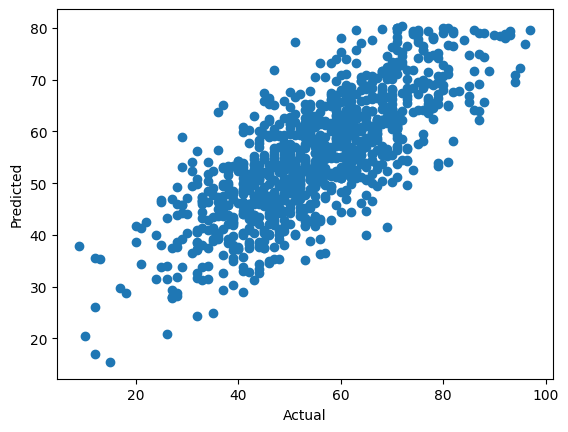

In [89]:
plt.scatter(y_test,y_pred);
plt.xlabel('Actual');
plt.ylabel('Predicted');

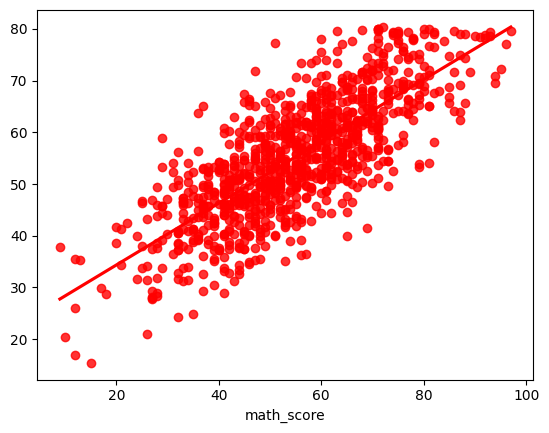

In [90]:
sns.regplot(x=y_test,y=y_pred,ci=None,color ='red');

#### Difference between Actual and Predicted Values

In [91]:
pred_df=pd.DataFrame({'Actual Value':y_test,'Predicted Value':y_pred,'Difference':y_test-y_pred})
pred_df

,Actual Value,Predicted Value,Difference
1501,34,31.449191,2.550809
2586,43,43.794895,-0.794895
2653,54,61.530344,-7.530344
1055,58,65.204726,-7.204726
705,47,71.943905,-24.943905
...,...,...,...
4711,65,57.848086,7.151914
2313,69,64.614641,4.385359
3214,88,74.385901,13.614099
2732,79,66.476354,12.523646


In [92]:
with open(artifacts / 'ridge_regression.pkl', 'wb') as f:
    pickle.dump(lin_model, f)


### saved model